In [1]:
!cd .. && maturin build --release

🍹 Building a mixed python/rust project
🔗 Found pyo3 bindings
🐍 Found CPython 3.9 at python3.9
📦 Built source distribution to /home/ubuntu/omelette/target/wheels/rejoice-0.1.0.tar.gz
   Compiling rejoice v0.1.0 (/home/ubuntu/omelette)
    Finished release [optimized] target(s) in 7.72sejoice                     
📦 Built wheel for CPython 3.9 to /home/ubuntu/omelette/target/wheels/rejoice-0.1.0-cp39-cp39-manylinux_2_27_x86_64.whl


In [8]:
%pip install /home/ubuntu/omelette/target/wheels/rejoice-0.1.0-cp39-cp39-manylinux_2_27_x86_64.whl --force-reinstall

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Processing /home/ubuntu/omelette/target/wheels/rejoice-0.1.0-cp39-cp39-manylinux_2_27_x86_64.whl
  Attempting uninstall: rejoice
    Found existing installation: rejoice 0.1.0
    Uninstalling rejoice-0.1.0:
      Successfully uninstalled rejoice-0.1.0
Note: you may need to restart the kernel to use updated packages.


In [1]:
import sys
sys.path.append('..')
import importlib
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as pyg
from tbparse import SummaryReader
import pandas as pd
import numpy as np
import seaborn as sns
from natsort import natsorted
import matplotlib.pyplot as plt
import networkx as nx
import os
from itertools import groupby
from collections import namedtuple
import math
import time
from PropLang import PropLang
from MathLang import MathLang
import rejoice
from rejoice import EGraph
from rejoice.lib import Language
from rejoice.pretrain_dataset_gen import EGraphSolver
from os import listdir

/home/ubuntu/anaconda3/envs/omelette/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-06-19 10:18:07.349979: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [ ]:
# !sudo apt install --yes cm-super dvipng texlive-fonts-recommended texlive-latex-extra texlive-latex-recommended

In [2]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'cm'
plt.rcParams['font.size'] = 18

plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200

# Limitations of Equality Saturation

In [11]:
def run_egg(lang: Language, expr, node_limit=10_000, iter_limit=7):
    print(f"running egg for expr", expr)
    first_stamp = int(round(time.time() * 1000))
    egraph = EGraph()
    egraph.add(expr)
    stop_reason, num_applications, num_enodes, num_eclasses = egraph.run(lang.rewrite_rules(), iter_limit=iter_limit, node_limit=node_limit)
    print(stop_reason, "num_applications", num_applications, "num_enodes", num_enodes, "num_eclasses", num_eclasses)
    best_cost, best_expr = egraph.extract(expr)
    second_stamp = int(round(time.time() * 1000))
    # Calculate the time taken in milliseconds
    time_taken = second_stamp - first_stamp
    # egraph.graphviz("egg_best.png")
    print(f"egg best cost:", best_cost, "in",
            f"{time_taken}ms", "best expr: ", best_expr)
    return best_cost, best_expr, num_applications, num_enodes

running egg for expr Sub(x=Add(x=16, y=2), y=0)
NODE_LIMIT num_applications 5093 num_enodes 9708 num_eclasses 4420
egg best cost: 3 in 1104ms best expr:  Add(x=16, y=2)
matched egg cost. Finding minimum sequence...
[0, 4, 6, 8]
found best 3.0 Add(x=16, y=2) [4, 6, 8, 26]
hit node limit when searching...


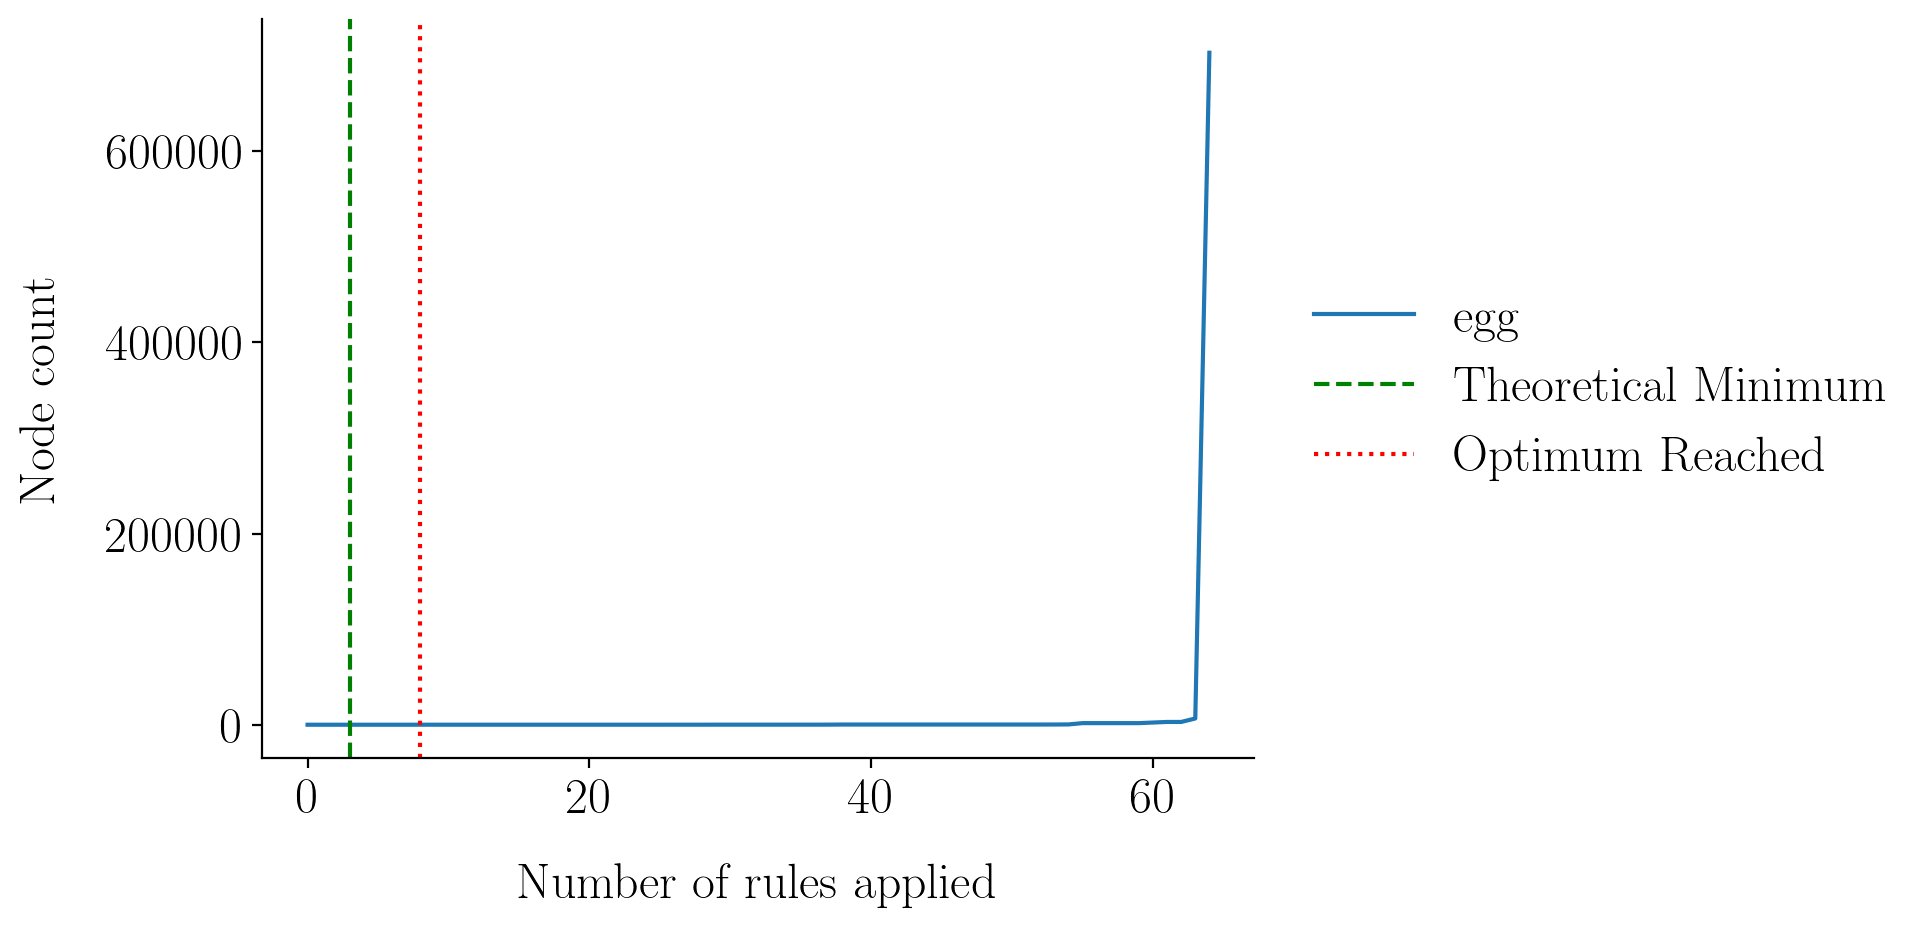

In [8]:
lang = MathLang()
ops = lang.all_operators_obj()
Add, Integral, Mul, Pow, Diff, Ln, Div, Cos, Sub, Sqrt = ops.add, ops.integral, ops.mul, ops.pow, ops.diff, ops.ln, ops.div, ops.cos, ops.sub, ops.sqrt
expr = ops.sub(ops.add(16, 2), 0)
best_cost, _, _, _ = run_egg(lang, expr, 1_000, 7)
solver = EGraphSolver(lang=lang, expr=expr, node_limit=1_000)
steps = solver.optimize(max_steps=10000)
df = pd.DataFrame(steps)
df["label"] = "optimal"
solver2 = EGraphSolver(lang=lang, expr=expr, node_limit=10_000)
steps2 = solver2.egg_like(max_steps=100_000)
df2 = pd.DataFrame(steps2)
df2["label"] = "egg"

best_cost_ind = df2["cost"].eq(best_cost).idxmax()

df3 = df2.reset_index()
ax = sns.lineplot(data=df3, x="index", y="num_enodes", hue="label")
sns.despine(top=True, right=True)
ax.xaxis.labelpad = 15
ax.yaxis.labelpad = 15

ax.axvline(len(df), linestyle='--', color='green', label="Theoretical Minimum")
ax.axvline(best_cost_ind, linestyle=':', color='red', label="Optimum Reached")
leg = plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
leg.set_frame_on(False)
ax.set_xlabel("Number of rules applied")
ax.set_ylabel("Node count")

plt.savefig("sync/egg_node_count_math.pdf", bbox_inches='tight')


In [4]:
lang = PropLang()
ops = lang.all_operators_dict()
AND, NOT, OR, IM = ops["and"], ops["not"], ops["or"], ops["implies"]
x, y, z = "x", "y", "z"
expr = OR(AND(x, y), IM(x, z))
best_cost, _, _, _ = run_egg(lang, expr, 1_000, 7)
solver = EGraphSolver(lang=lang, expr=expr, node_limit=1_000)
steps = solver.optimize(max_steps=10000)
df = pd.DataFrame(steps)
df["label"] = "optimal"
solver2 = EGraphSolver(lang=lang, expr=expr, node_limit=10_000)
steps2 = solver2.egg_like(max_steps=100_000)
df2 = pd.DataFrame(steps2)
df2["label"] = "egg"

best_cost_ind = df2["cost"].eq(best_cost).idxmax()

df3 = df2.reset_index()
ax = sns.lineplot(data=df3, x="index", y="num_enodes", hue="label")
sns.despine(top=True, right=True)
ax.xaxis.labelpad = 15
ax.yaxis.labelpad = 15

ax.axvline(len(df), linestyle='--', color='green', label="Theoretical Minimum")
ax.axvline(best_cost_ind, linestyle=':', color='red', label="Optimum Reached")
leg = plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
leg.set_frame_on(False)
ax.set_xlabel("Number of rules applied")
ax.set_ylabel("Node count")

plt.savefig("sync/egg_node_count.pdf", bbox_inches='tight')


running egg for expr Or(x=And(x='x', y='y'), y=Implies(x='x', y='z'))
NODE_LIMIT num_applications 588 num_enodes 1133 num_eclasses 255
egg best cost: 5 in 41ms best expr:  Or(x='z', y=Implies(x='x', y='y'))
matched egg cost. Finding minimum sequence...
[0, 3, 4, 7, 8, 12, 2, 3, 4, 6, 7, 9, 11, 12, 2]


thread '<unnamed>' panicked at 'Failed to construct: PyErr { type: <class 'KeyboardInterrupt'>, value: KeyboardInterrupt(), traceback: Some(<traceback object at 0x7fe8a0e0dac0>) }', src/lib.rs:135:38
note: run with `RUST_BACKTRACE=1` environment variable to display a backtrace


PanicException: Failed to construct: PyErr { type: <class 'KeyboardInterrupt'>, value: KeyboardInterrupt(), traceback: Some(<traceback object at 0x7fe8a0e0dac0>) }

hit node limit when searching...


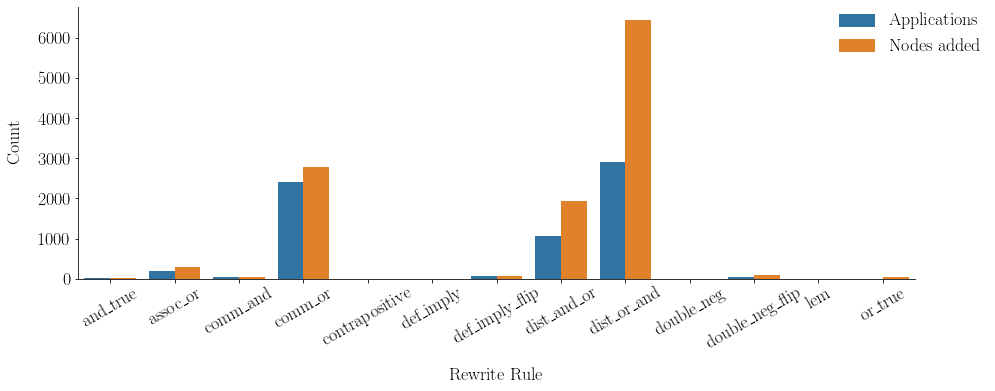

In [5]:
solver2 = EGraphSolver(lang=lang, expr=expr, node_limit=10_000)
steps2 = solver2.egg_like(max_steps=100_000)
df2 = pd.DataFrame(steps2)
df2["label"] = "egg"
df2["enodes_added"] = df2["num_enodes"].diff()
df2 = df2.groupby("action_name").agg('sum').reset_index()
df2 = df2[["action_name", "num_applications", "enodes_added"]]
df2 = df2.melt("action_name")
plt.rcParams['font.size'] = 18
plt.figure(figsize=(15, 5))
ax = sns.barplot(x="action_name", y="value", hue="variable", data=df2)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
sns.despine(top=True, right=True)
ax.xaxis.labelpad = 15
ax.yaxis.labelpad = 15

ax.set_xlabel("Rewrite Rule")
ax.set_ylabel("Count")
plt.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0)
leg = ax.axes.get_legend()
leg.set_frame_on(False)

new_labels = ['Applications', 'Nodes added']
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)

plt.savefig("sync/egg_limits_rules.pdf", bbox_inches='tight')

# Single-Task Performance

## Easy task

In [5]:
def smooth(scalars: list[float], weight=0.9) -> list[float]:  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
        
    return smoothed

/tmp/ipykernel_9820/2166855539.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prop["Lang"] = "PROP"
/tmp/ipykernel_9820/2166855539.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_math["Lang"] = "MATH"


running egg for expr Or(x=Not(x=Not(x=And(x=And(x=True, y=True), y=And(x=True, y='r')))), y=Not(x=Not(x='i')))
ITERATION_LIMIT num_applications 2160 num_enodes 3590 num_eclasses 27
egg best cost: 3 in 107ms best expr:  Or(x='r', y='i')
running egg for expr Sub(x=Add(x=16, y=2), y=0)
NODE_LIMIT num_applications 8517 num_enodes 16245 num_eclasses 6412
egg best cost: 3 in 882ms best expr:  Add(x=16, y=2)


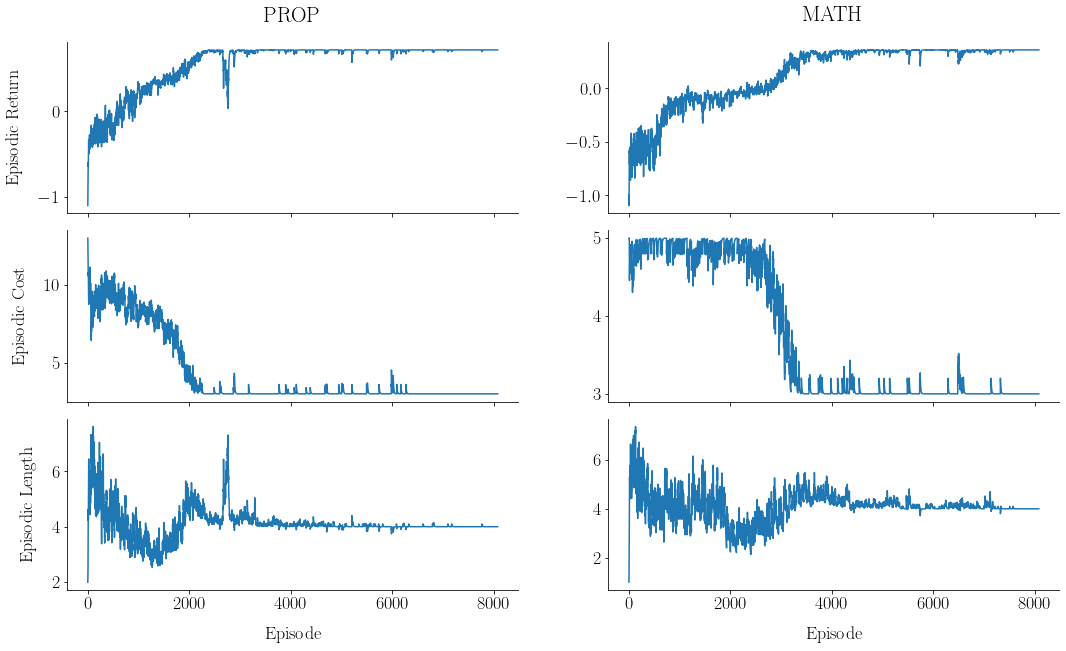

In [6]:
# Load log data
log_dir = "../ppo_logs/"
reader = SummaryReader(log_dir, extra_columns={'dir_name'})
df = reader.scalars
df_prop = df[df['dir_name'] == 'egraph-v0__ppo__1__1655144794']
df_prop["Lang"] = "PROP"
# TODO: change this
df_math = df[df['dir_name'] == 'egraph-v0__ppo__1__1655273840']
df_math["Lang"] = "MATH"

plang = PropLang()
psat_expr = plang.get_single_task_exprs().saturatable
psolver = EGraphSolver(lang=plang, expr=psat_expr)
p_best_cost, p_best_expr, p_num_applications, p_num_enodes = run_egg(plang, psat_expr)

mlang = MathLang()
msat_expr = mlang.get_single_task_exprs().saturatable
msolver = EGraphSolver(lang=mlang, expr=msat_expr)
m_best_cost, m_best_expr, m_num_applications, m_num_enodes = run_egg(mlang, msat_expr)

def smooth_tensorboard_plots(df):
    smoothed_return = smooth(df[df["tag"] == "charts/episodic_return"]["value"].tolist())
    smoothed_cost = smooth(df[df["tag"] == "charts/episodic_cost"]["value"].tolist())
    smoothed_length = smooth(df[df["tag"] == "charts/episodic_length"]["value"].tolist())
    df2 = pd.DataFrame({"Return": smoothed_return, "Cost": smoothed_cost, "Length": smoothed_length, "Lang": df.iloc[0]["Lang"]})
    return df2

def plot_single_task_easy_grid(df_prop, df_math):
    chart_list = ['charts/episodic_return', 'charts/episodic_cost', 'charts/episodic_length', 'charts/acc_rewrites']

    df_prop = df_prop.loc[df_prop['tag'].isin(chart_list)]
    df_math = df_math.loc[df_math['tag'].isin(chart_list)]

    df_prop = df_prop[df_prop["step"] < 130_000]
    df_math = df_math[df_math["step"] < 130_000]
    # find steps where episodic_cost is minimum
    # then get min of acc_rw of those rows
    # df_prop.groupby("step")
    df_prop_minlen = 7

    df_prop = smooth_tensorboard_plots(df_prop)
    df_math = smooth_tensorboard_plots(df_math)

    df_math_minlen = 4
    
    df_all = pd.concat([df_prop, df_math])

    df = pd.melt(df_all, id_vars=["Lang"], ignore_index=False)
    # plt.figure(figsize=(5, 10))
    g = sns.relplot(x=df.index, y="value", row="variable", col="Lang", kind="line", data=df, facet_kws={'sharey': False, 'sharex': False}, height=3, aspect=2.5/1)

    # g.set(xlabel="Episode")
    g.fig.subplots_adjust(wspace=.2, hspace=.1)
    ylabels = ["Episodic Return", "",
              "Episodic Cost", "",
              "Episodic Length", ""]

    for ind, ax in enumerate(g.axes.flatten()):
        if ind == 0:
            ax.set_title("PROP", pad=20, fontweight="bold")
        elif ind == 1:
            ax.set_title("MATH", pad=20, fontweight="bold")
        else:
            ax.set_title("")

        if ind not in [4, 5]:
            ax.set(xticklabels=[])
    
        ax.set_ylabel(ylabels[ind])
        ax.yaxis.labelpad = 15
        ax.xaxis.labelpad = 15
        ax.set_xlabel("")
        if ind in [4, 5]:
            ax.set_xlabel("Episode")

    # create separate barplot
    # Lang, num_applications_egg, num_applications_omelette
    data = [["PROP", p_num_applications, df_prop_minlen],
            ["MATH", m_num_applications, df_math_minlen]]
    df = pd.DataFrame(data, columns=["Lang", "Egg", "Omelette"])   
    df = df.melt(["Lang"])
    return g, df

g, bpdf = plot_single_task_easy_grid(df_prop, df_math)
g.fig.savefig("sync/single_task_easy.pdf", bbox_inches='tight')

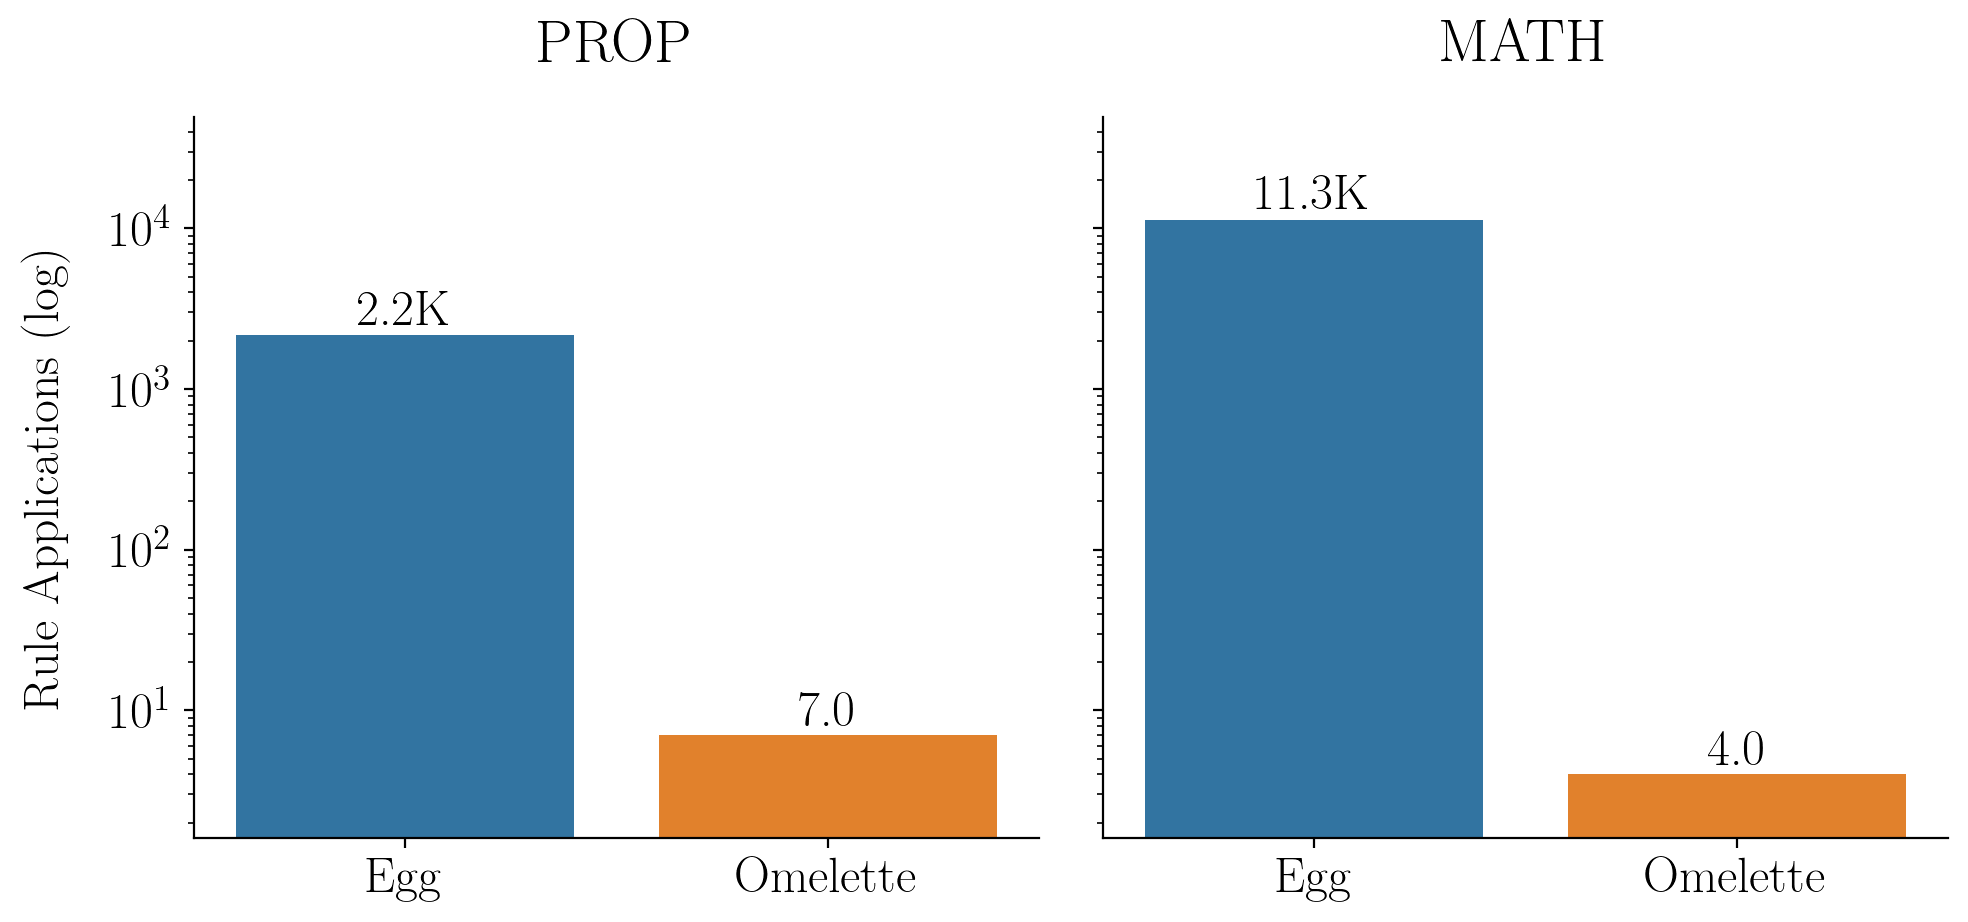

In [45]:
bp = sns.catplot(x="variable", y="value",
            col="Lang",
            kind="bar", data=bpdf, log=True)

bp.set_ylabels("Rule Applications (log)")

# iterate through axes
for ax in bp.axes.ravel():
    
    # add annotations
    for c in ax.containers:
        labels = [f'{(v.get_height() / 1000):.1f}K' if v.get_height() > 100 else f'{v.get_height():2}' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')
    ax.margins(y=0.2)

titles = ["PROP", "MATH"]
for ind, ax in enumerate(bp.axes.flatten()):
    ax.yaxis.labelpad = 15
    ax.xaxis.labelpad = 15
    ax.set_xlabel("")
    ax.set_title(titles[ind], pad=20, fontweight="bold")

bp.savefig("sync/num_apps.pdf")


## Exploding Task

# Pretraining Graphs

### PROP

##### Dataset analysis

In [15]:
def load_dataset(dataset_dir: str):
  files = os.listdir(dataset_dir)
  files.sort()
  keyf = lambda f: f.split("_")[0]

  files_grouped_by_expr = [list(expr_files) for gr, expr_files in groupby(files, key=keyf)]

  Row = namedtuple('Row', ['max_cost', 'min_cost', 'om_actions', 'egg_actions', 'action_mult', 'om_enodes', 'egg_enodes', 'enodes_mult', 'om_eclasses', 'egg_eclasses', 'eclasses_mult'])

  rows = []

  for group in files_grouped_by_expr:
    min_actions = len(group)
    # pick the last data object (the one from termination)
    d = torch.load(dataset_dir + "/" + group[-1])
    num_eclasses = int(torch.sum(d["x"][:, 0]).item())
    num_enodes = int(len(d["x"]) - num_eclasses)

    node_mult = (d.egg_enodes / num_enodes)
    class_mult = (d.egg_eclasses / num_eclasses)
    action_mult = (d.egg_rewrites / min_actions)

    rows.append(Row(max_cost=d.max_cost, min_cost=d.min_cost, om_actions=min_actions, egg_actions=d.egg_rewrites, action_mult=action_mult,
        om_enodes=num_enodes, egg_enodes=d.egg_enodes, enodes_mult=node_mult,
        om_eclasses=num_eclasses, egg_eclasses=d.egg_eclasses, eclasses_mult=class_mult))
    
  return pd.DataFrame(rows)

Data(x=[49, 23], edge_index=[2, 129], edge_attr=[129, 2], y=[1], action_mask=[14], max_cost=15, min_cost=1.0, egg_rewrites=358, egg_enodes=473, egg_eclasses=82)
Data(x=[17, 23], edge_index=[2, 46], edge_attr=[46, 2], y=[1], action_mask=[14], max_cost=14, min_cost=2.0, egg_rewrites=429, egg_enodes=614, egg_eclasses=72)
Data(x=[65, 23], edge_index=[2, 150], edge_attr=[150, 2], y=[1], action_mask=[14], max_cost=17, min_cost=11.0, egg_rewrites=2443, egg_enodes=3269, egg_eclasses=616)
Data(x=[45, 23], edge_index=[2, 106], edge_attr=[106, 2], y=[1], action_mask=[14], max_cost=11, min_cost=7.0, egg_rewrites=498, egg_enodes=724, egg_eclasses=88)
Data(x=[93, 23], edge_index=[2, 224], edge_attr=[224, 2], y=[1], action_mask=[14], max_cost=29, min_cost=23.0, egg_rewrites=3085, egg_enodes=4111, egg_eclasses=876)
Data(x=[49, 23], edge_index=[2, 139], edge_attr=[139, 2], y=[1], action_mask=[14], max_cost=21, min_cost=3.0, egg_rewrites=1344, egg_enodes=2011, egg_eclasses=172)
Data(x=[13, 23], edge_ind

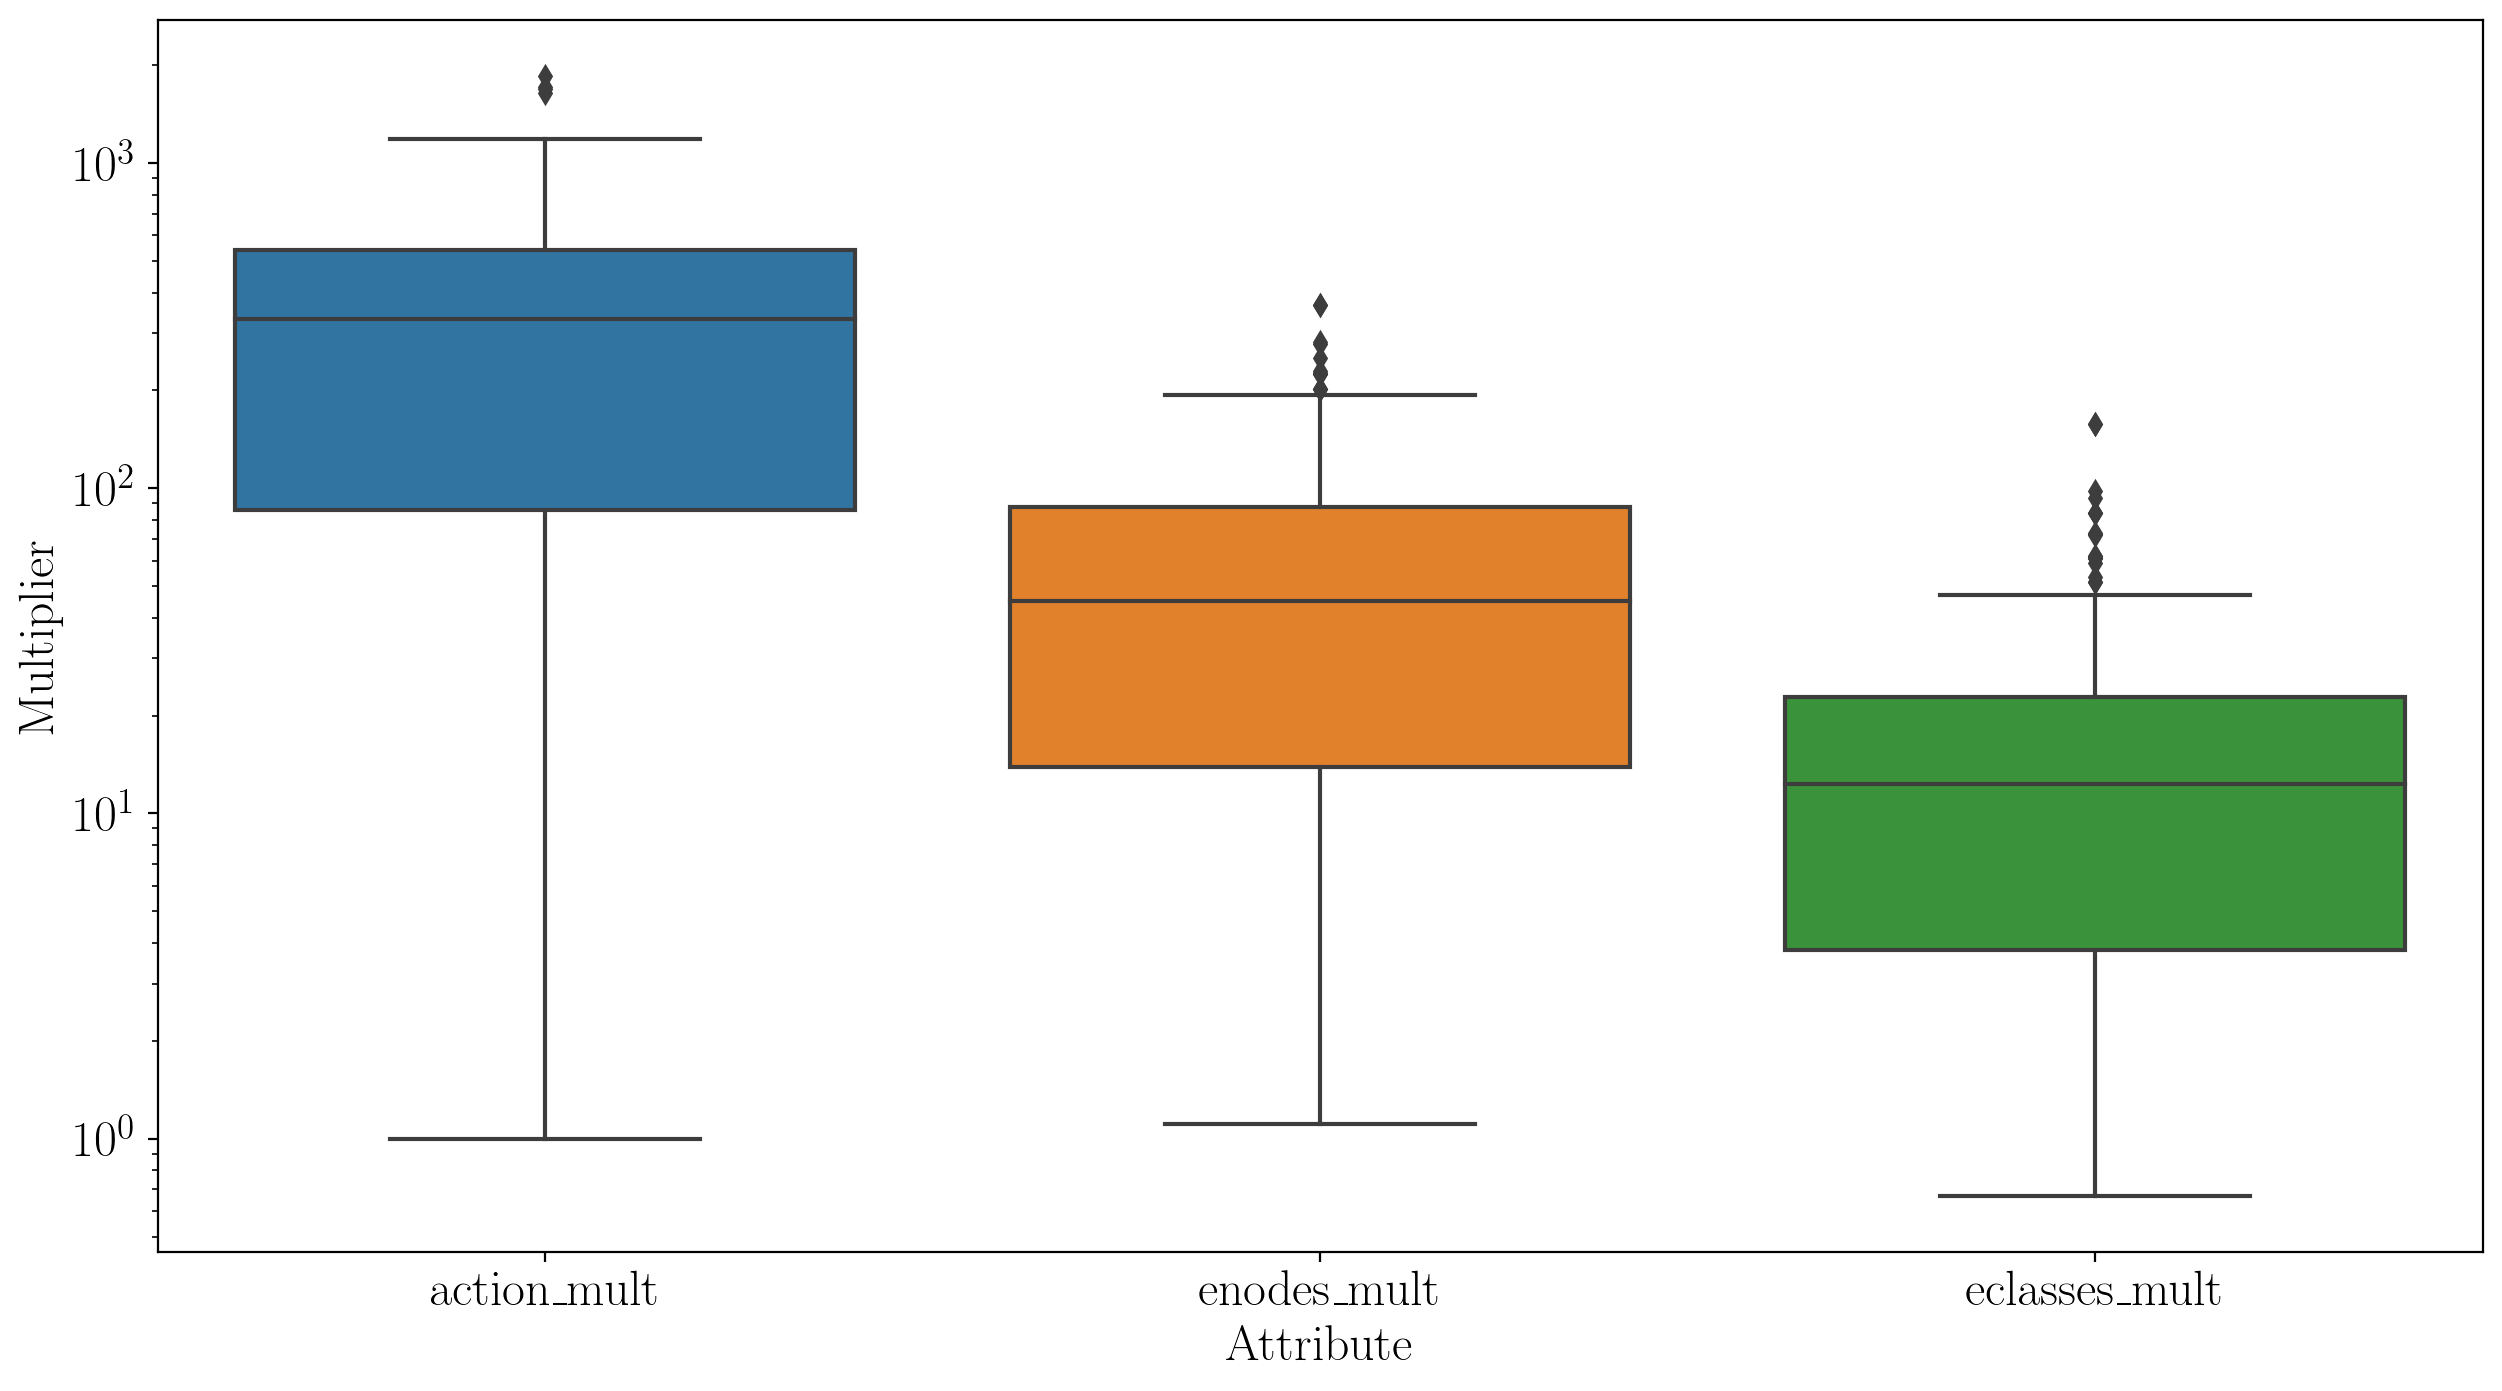

In [16]:
df = load_dataset("../PropLang")
print(df)
df = df[["action_mult", "enodes_mult", "eclasses_mult"]]
df_melted = pd.melt(df)
plt.figure(figsize = (15,8))
g = sns.boxplot(x='variable', y='value', data=df_melted)
g.set(ylabel="Multiplier", xlabel="Attribute", yscale="log")
plt.savefig("prop_data.pdf")

In [13]:
df = load_dataset("../PropLang")
data = pd.DataFrame({"Egg": [df["egg_actions"].mean()], "Omelette": [df["om_actions"].mean()]})
data = pd.melt(data)
print(data)

   variable        value
0       Egg  1619.995146
1  Omelette     4.669903


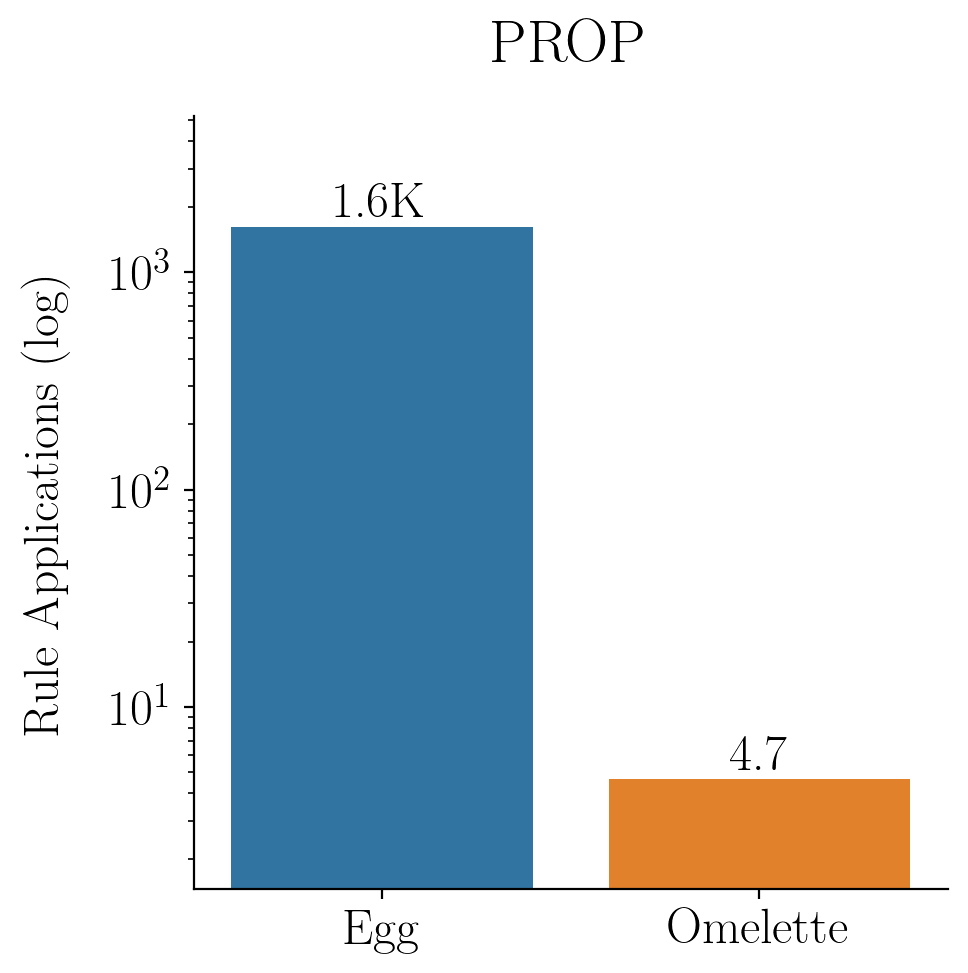

In [22]:

bp = sns.catplot(x="variable", y="value",
            kind="bar", data=data, log=True)

bp.set_ylabels("Rule Applications (log)")

# iterate through axes
for ax in bp.axes.ravel():
    
    # add annotations
    for c in ax.containers:
        labels = [f'{(v.get_height() / 1000):.1f}K' if v.get_height() > 100 else f'{v.get_height():.1f}' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')
    ax.margins(y=0.2)

titles = ["PROP", "MATH"]
for ind, ax in enumerate(bp.axes.flatten()):
    ax.yaxis.labelpad = 15
    ax.xaxis.labelpad = 15
    ax.set_xlabel("")
    ax.set_title(titles[ind], pad=20, fontweight="bold")

bp.savefig("sync/num_apps_dataset.pdf")

##### Training/Test Accuracy Plots

In [ ]:
# Load log data
log_dir = "../lightning_logs/"
reader = SummaryReader(log_dir, extra_columns={'dir_name'})
df = reader.scalars
df_prop = df[df['dir_name'] == 'prop']
df_math = df[df['dir_name'] == 'math']


In [ ]:
def plot_acc(df, title):
  g = sns.lineplot(data=df, x='step', y='value')
  g.set(title=title, ylabel="Accuracy", xlabel="Step")
  return g

In [ ]:
def plot_acc_grid(df1, df2):
  df1 = df1.loc[df1['tag'].isin(['acc/train_acc', 'acc/val_acc'])]
  df2 = df2.loc[df2['tag'].isin(['acc/train_acc', 'acc/val_acc'])]
  df_all = pd.concat([df1, df2])

  g = sns.relplot(x="step", y="value", col="tag", row="dir_name", kind="line", data=df_all);
  g.set(ylabel="Accuracy", xlabel="Step")
  return g

g = plot_acc_grid(df_prop, df_math)
plt.savefig("sup_acc.pdf")

In [ ]:
train_acc_df = df[df['tag'] =='acc/train_acc']
plot_acc(train_acc_df, "Training Accuracy")

In [ ]:
al_acc_df = df[df['tag'] =='acc/val_acc']


# Single-Task Performance

In [160]:
def load_data():
    dfs = []
    for file in listdir("../dataset_metrics"):
        fsplit = file.split("_")
        expr_ind = fsplit[1]
        df = pd.read_feather(f"../dataset_metrics/{file}")
        df["expr_ind"] = expr_ind

        if fsplit[2] == "om":
            # om doesn't end when it's done, manually slice
            min_ind = df["cost"].idxmin()
            df = df.iloc[:min_ind+1]
        dfs.append(df)

    df = pd.concat(dfs)
    df = df.sort_values(["expr_ind", "step_ind"])
    return df


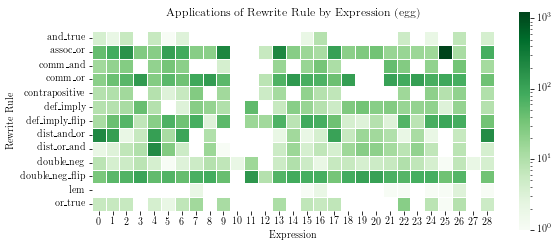

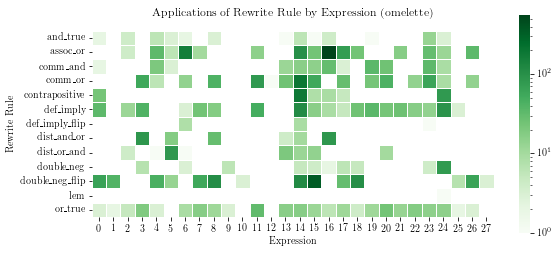

In [164]:
# Rule application heatmap
from matplotlib.colors import LogNorm

df = load_data()
egg = df[df["solver"] == "egg"]
om = df[df["solver"] == "omelette"]

hm_egg = egg.groupby(["expr_ind", "action_name"])["num_applications"].sum().unstack(level=0, fill_value=0)
hm_egg = hm_egg.reindex(natsorted(hm_egg.columns), axis=1)

hm_om = om.groupby(["expr_ind", "action_name"])["num_applications"].sum().unstack(level=0, fill_value=0)
hm_om = hm_om.reindex(natsorted(hm_om.columns), axis=1)

def rule_app_hm(data, solver):
    plt.figure(figsize = (9,4))
    green = sns.color_palette("Greens", as_cmap=True).copy()
    green.set_under('white')
    g = sns.heatmap(data, cmap=green, vmin=1, square=True, linewidths=.5, norm=LogNorm())
    g.set_title(f"Applications of Rewrite Rule by Expression ({solver})", pad=15, fontweight="bold")
    g.set(xlabel="Expression", ylabel="Rewrite Rule")
    g.get_figure().savefig(f"sync/rule_app_hm_{solver}.pdf", bbox_inches='tight')

rule_app_hm(hm_egg, "egg")
rule_app_hm(hm_om, "omelette")

In [196]:
def expr_summary():
    """Collapse each expression to a row summarizing it."""
    df = load_data()
    
    grouped = df.groupby(['expr_ind', 'solver']).agg({
        'step_ind': 'last',
        'stop_reason': 'last',
        'cost': 'last',
        'num_enodes': 'last',
        'num_eclasses': 'last',
        'training_time': 'last',
        'num_applications': 'sum',
    })
    grouped['training_time'] = grouped['training_time'] / 60_000 # convert to min
    grouped['step_ind'] = grouped['step_ind'] + 1 # convert index to step count
    grouped = grouped.rename(columns={'step_ind': 'num_actions'}).reset_index()
    grouped = grouped.pivot(index = "expr_ind", columns = "solver")
    grouped = grouped.sort_values(
        by=["expr_ind"],
        key=natsort_keygen()
    )

    return grouped

expr_summary()

num_actions          stop_reason                    cost           \
solver           egg omelette         egg         omelette    egg omelette   
expr_ind                                                                     
0               19.0     23.0  NODE_LIMIT  ITERATION_LIMIT    6.0      4.0   
1               19.0      2.0  NODE_LIMIT  ITERATION_LIMIT   36.0     65.0   
2               18.0      5.0  NODE_LIMIT  ITERATION_LIMIT   39.0     55.0   
3                8.0      8.0  NODE_LIMIT  ITERATION_LIMIT  182.0     68.0   
4               20.0      9.0  NODE_LIMIT  ITERATION_LIMIT   54.0     56.0   
5               31.0     12.0  NODE_LIMIT  ITERATION_LIMIT   12.0     12.0   
6               19.0     10.0  NODE_LIMIT  ITERATION_LIMIT   36.0     17.0   
7               17.0      7.0  NODE_LIMIT  ITERATION_LIMIT   21.0     19.0   
8                8.0     10.0  NODE_LIMIT  ITERATION_LIMIT  165.0      1.0   
9               18.0      2.0  NODE_LIMIT  ITERATION_LIMIT    3.0      7.0   
10              26.0      1.0   SATURATED  ITERATION_LIMIT    2.0      2.0   
11               4.0     10.0  NODE_LIMIT  ITERATION_LIMIT  315.0     71.0   
12              65.0      1.0   SATURATED  ITERATION_LIMIT    8.0      8.0   
13              18.0     11.0  NODE_LIMIT  ITERATION_LIMIT   17.0      7.0   
14               8.0     59.0  NODE_LIMIT  ITERATION_LIMIT  159.0     33.0   
15              17.0     29.0  NODE_LIMIT  ITERATION_LIMIT   23.0     29.0   
16              17.0     12.0  NODE_LIMIT       NODE_LIMIT   52.0     54.0   
17              19.0     10.0  NODE_LIMIT  ITERATION_LIMIT    7.0      1.0   
18               8.0      6.0  NODE_LIMIT  ITERATION_LIMIT  165.0    145.0   
19               7.0      8.0  NODE_LIMIT  ITERATION_LIMIT  225.0      1.0   
20               7.0      8.0  NODE_LIMIT  ITERATION_LIMIT  231.0      9.0   
21              10.0      4.0  NODE_LIMIT  ITERATION_LIMIT  121.0     49.0   
22              16.0      6.0  NODE_LIMIT  ITERATION_LIMIT   12.0      2.0   
23               8.0     19.0  NODE_LIMIT  ITERATION_LIMIT  171.0     39.0   
24              17.0     18.0  NODE_LIMIT  ITERATION_LIMIT   45.0     17.0   
25              44.0      5.0  NODE_LIMIT  ITERATION_LIMIT    2.0      2.0   
26              16.0      5.0  NODE_LIMIT  ITERATION_LIMIT   63.0     91.0   
27              26.0      1.0   SATURATED  ITERATION_LIMIT    2.0      2.0   
28              19.0     34.0  NODE_LIMIT  ITERATION_LIMIT   13.0     11.0   
29               6.0      NaN  NODE_LIMIT              NaN  225.0      NaN   
30              26.0      1.0   SATURATED  ITERATION_LIMIT    9.0      9.0   
31              19.0      NaN  NODE_LIMIT              NaN   17.0      NaN   

         num_enodes          num_eclasses          training_time             \
solver          egg omelette          egg omelette           egg   omelette   
expr_ind                                                                      
0             686.0      7.0        272.0      4.0           0.0  11.605967   
1             682.0    123.0        256.0     76.0           0.0  38.120183   
2             728.0    106.0        211.0     63.0           0.0  37.376967   
3             586.0    417.0        234.0    130.0           0.0  61.265583   
4             845.0    244.0        310.0    100.0           0.0  31.044067   
5             602.0    371.0        205.0    149.0           0.0  22.148033   
6             623.0    391.0        192.0    141.0           0.0  30.291017   
7             513.0    237.0         96.0     77.0           0.0  28.984550   
8             537.0    439.0        237.0    156.0           0.0  38.128733   
9             749.0     55.0        249.0     37.0           0.0  21.170083   
10              4.0      5.0          2.0      2.0           0.0   7.219450   
11            546.0    371.0        288.0    148.0           0.0  43.226000   
12             58.0      6.0         16.0      5.0           0.0   8.646917   
13            

In [139]:
from natsort import natsort_keygen

# per-expr cost
df = load_data()

df = df.groupby(["expr_ind", "solver"])["cost"].min().reset_index()
df = df.sort_values(
    by=["expr_ind", "solver"],
    key=natsort_keygen()
)

df = df.groupby('expr_ind').apply(lambda x: x.cost.tolist()).apply(pd.Series).reset_index().rename(columns={"expr_ind": "Expression", 0: "egg", 1: "omelette"})
df['% Improvement'] = (df.egg - df.omelette) / df.egg * 100
df = df.set_index("Expression")
df = df.sort_values(
    by=["Expression"],
    key=natsort_keygen()
).reset_index(drop=True)

print(df)
s = df.to_latex(float_format="%.1f", bold_rows=True)

with open("sync/cost_table.tex", "w") as text_file:
    text_file.write(s)


# need to somehow get the last step_ind of each expr_ind

      egg  omelette  % Improvement
0     6.0       4.0      33.333333
1    36.0      65.0     -80.555556
2    39.0      55.0     -41.025641
3   182.0      68.0      62.637363
4    54.0      56.0      -3.703704
5    12.0      12.0       0.000000
6    36.0      17.0      52.777778
7    21.0      19.0       9.523810
8   165.0       1.0      99.393939
9     3.0       7.0    -133.333333
10    2.0       2.0       0.000000
11  315.0      71.0      77.460317
12    8.0       8.0       0.000000
13   17.0       7.0      58.823529
14  159.0      33.0      79.245283
15   23.0      29.0     -26.086957
16   52.0      54.0      -3.846154
17    7.0       1.0      85.714286
18  165.0     145.0      12.121212
19  225.0       1.0      99.555556
20  231.0       9.0      96.103896
21  121.0      49.0      59.504132
22   12.0       2.0      83.333333
23  171.0      39.0      77.192982
24   45.0       NaN            NaN


/tmp/ipykernel_31017/3109588720.py:21: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  s = df.to_latex(float_format="%.1f", bold_rows=True)


In [33]:
from anytree import Node, RenderTree, NodeMixin

class Node(NodeMixin):
    def __init__(self, name, parent=None, children=None):
        super(self, Node).__init__()
        self.name = name
        self.parent = parent
        if children:
            self.children = children
        

# Expression table
df = load_data()
ind_to_expr = df[["expr_ind", "init_expr"]].drop_duplicates()

e = ind_to_expr.iloc[0]["init_expr"].replace("x=", "").replace("y=", "")
print(e)
# start = 0
# end = len(e)
# c = 0
# consumable = e

# ops = ["And", "Or", "Implies", "Not"]

# nodes = []
# while True:
#     for op in ops:
#         if e[c:].startswith(op):
#             Node(op, parent=nodes[-1])
#             c += len(op)
#             break

            
    




Not(And(And(False, False), And(True, Not(Not(Implies(Implies(True, Implies(Implies(True, 'b'), Implies(Not(Not(Not(Not('a')))), False))), Implies(Implies(Implies('b', False), Implies(And(And(True, And(And(False, False), And('b', False))), And(And(And(False, 'a'), And('a', 'b')), False)), True)), Not(Not(Not(Not(True)))))))))))


# Generalizability